In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

/opt/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA ANALYSIS

In [2]:
df = pd.read_csv('dataset/mock_kaggle.csv', parse_dates=['data'])
print(df.shape)

df['id'] = 1
df.rename(columns={'data': 'timestamp'}, inplace=True)
df.tail()

(937, 4)


,timestamp,venda,estoque,preco,id
932,2016-07-27,98,3179,2.39,1
933,2016-07-28,108,3071,2.39,1
934,2016-07-29,128,4095,2.39,1
935,2016-07-30,270,3825,2.39,1
936,2016-07-31,183,3642,2.39,1


In [5]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df[:900],
    id_column="id",
    timestamp_column="timestamp"
)

predictor = TimeSeriesPredictor(
    prediction_length=37,
    target="venda",
    eval_metric="MASE",
    freq="D",
    known_covariates_names=["estoque", "preco"],
    path='model'
)

In [6]:
predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=900,
    num_val_windows=3,
)

Beginning AutoGluon training... Time limit = 900s
AutoGluon will save models to 'model'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:16:51 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.94 GB / 8.00 GB (24.3%)
Disk Space Avail:   30.33 GB / 228.27 GB (13.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': ['estoque', 'preco'],
 'num_val_windows': 3,
 'prediction_length': 37,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'venda',
 'time_limit': 900,
 'verbosity': 2}

train_data wi

In [7]:
covariates = TimeSeriesDataFrame.from_data_frame(
    df[['id', 'timestamp', 'estoque', 'preco']], 
    timestamp_column="timestamp", 
    id_column="id"
)

forecast = predictor.predict(train_data, known_covariates=covariates)
forecast.head()

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2016-06-25  351.624255  204.912705  259.666517  269.351365   
        2016-06-26  321.694017  162.765675  219.106552  237.732947   
        2016-06-27  140.577787   25.604772   66.356312   82.422847   
        2016-06-28  117.235341   -6.014750   38.547819   56.795706   
        2016-06-29  157.812265   19.386399   70.014993   91.346331   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2016-06-25  299.778075  351.624255  374.916924  421.337804   
        2016-06-26  276.292569  321.694017  357.966116  402.730618   
        2016-06-27  118.170343  140.577787  162.836030  200.350464   
        2016-06-28   95.175667  117.235341  142.510088  182.170704   
        2016-06-29  129.343465  157.812265  186.241110  230.742341   

                           0.8         0.9  
item_id timestamp                           
1       2016-06-25  452.963387  493.241102  
        2016-06-26  443.140154  493.024444  
        2016-06-27  223.524466  269.654561  
        2016-06-28  208.203510  256.899407  
        2016-06-29  260.709596  315.838435

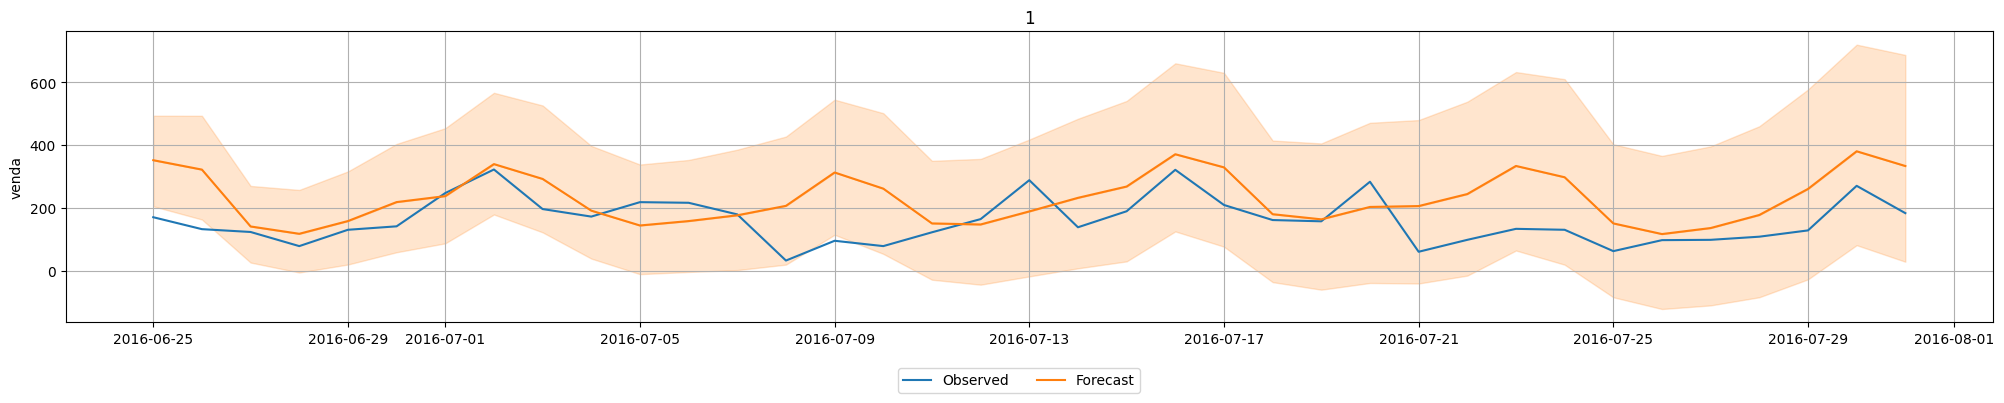

In [9]:
test_data = TimeSeriesDataFrame.from_data_frame(
    df[900:],
    id_column="id",
    timestamp_column="timestamp"
)

predictor.plot(test_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [10]:
predictor.evaluate(train_data)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -1.1034828625023063}